In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from matplotlib.animation import FuncAnimation

In [2]:
class Experience():
    def __init__(self):
        self.data = []
        self.total_data = {}
        
    def add_experience(self,experience): # 자기의 경험만 저장
        self.data.append(experience)
        
        
    def add_other_experience(self,add_person_idx,person): # 남의 경험 저장
        self.total_data[add_person_idx]  = person[add_person_idx].data 
        
    def remove_other_experience(self,remove_person_idx): # 남의 경험 제거
        del self.data[remove_person_idx]


# 노드 class

In [3]:
class Person:
    def __init__(self, idx):
        self.idx = idx
        self.name = 'node'
        self.color = 'red'
        self.size = 500
        
        self.input_nodes = []
        self.output_nodes = []
        
        self.access = 0
        self.denied = 0
        self.total_capitals = 100
        self.alpha  = 1
        
        
        self.criterion = [0 , 0] # 기준치 변경
        self.reputation = 0.5 # 신뢰도
        self.total_node_num = len(self.input_nodes) + len(self.output_nodes) # 총 연결수
        self.total_node_rate = 0 # 총 생산수 받은것분의 준것
        
        self.try_experience = 1
        self.experience_data = []
    
    

         
    def get_reputation(self): # 사회에서 인정받은 정도 신뢰성
        return self.reputation
        
        
    def update_reputation(self, success,another):
        if success:
            self.access += 1# * another.total_capitals
        else:
            self.denied += 1 #* another.total_capitals # 신뢰도 가진 자본으로 측정 단순히 성공 실패가 아닌 어떤사람한테 성공했는지 어떤사람한테 실패했는지 파악 다른 반대값 들어가야함 별거없는 애한테 무시당했으면 타격이 더큼 
            
        
        if (self.access + self.denied) == 0:
            self.reputation = 0
        else:
            self.reputation = self.access / (self.access + self.denied)
        
        
    def make_random_criterion(self):# 각자의 기준 생성
        x1 = random.random()
        x2 = random.random()
        
        min_ = min(x1,x2)
        max_ = max(x1,x2)
        
        self.criterion = [min_ , max_]
        
        return min_ , max_


# 네트워크 

In [4]:
class SocialNetwork:
    def __init__(self):
        self.person_dict = {}
        self.information_all = {}
        self.information_individual = {}
        self.step = 1
        
    def create_person(self,person_num): # 사람 생성
        for i in range(person_num):
            idx = i + 1
            person = Person(idx) # idx 1부터 생성
            self.person_dict[idx] = person
        
        
    def add_person(self, person): # 새로운 사람 생성
        self.person_dict[person.person_id] = person
        
        
    def connect_persons(self,connect_num): # 새로운 사람들간의 연결 생성
        for i in range(connect_num):
            persons_num = len(self.person_dict)
            s = np.random.randint(1, persons_num)
            e = np.random.randint(1, persons_num)
            self.person_dict[s].output_nodes.append(self.person_dict[e].idx)
            self.person_dict[e].input_nodes.append(self.person_dict[s].idx)
        
        
    def new_connect(self,find_num): # 탐색을 통한 새로운 구조 창출 및 기준치에 맞는 구조 교체
        
        for person in self.person_dict.values(): # 나중에 추후 새로운 기준 가져올때 experience 저장하기 -> 새롭게  
            person_criterion_output_x1 , person_criterion_output_x2 = person.make_random_criterion()
            person.criterion = person_criterion_output_x1 , person_criterion_output_x2 # 업데이트
            person_reputation = person.get_reputation()
            
            for i in range(find_num): # 새롭게 연결할것 find 하기 output 만 있으면 됨 직접 주는것만 
                another_input = self.person_dict[np.random.randint(1, len(self.person_dict))]
                another_criterion_input_x1 , another_criterion_input_x2 = another_input.make_random_criterion() # 새롭게 기준을 만든다는것보다 가져온다고 생각할 필요성 있음
                another_reputation = another_input.get_reputation()

                if person_criterion_output_x1 < another_reputation < person_criterion_output_x2: # 다른사람이 나의 기준에 충족 -> 내가 다른사람에게 정보를 줌
                    if another_criterion_input_x1 < person_reputation < another_criterion_input_x2:#다른 사람이 연결을 허락했을떄
                        person.output_nodes.append(another_input.idx)
                        another_input.input_nodes.append(person.idx)
                        another_input.update_reputation(True,another_input)
                    else: #다른 사람이 연결을 불허했을떄
                        person.update_reputation(False,another_input)
                    

            for another_input_index in person.output_nodes: # 내가 주고 있는 연결지점중에 끊을것들 찾기
                another_input = self.person_dict[another_input_index]
                another_criterion_input_x1 , another_criterion_input_x2 = another_input.make_random_criterion()
                if not another_criterion_input_x1 < person_reputation < another_criterion_input_x2  : # 내가 다른사람의 기준에 충족  -> 다른사람이 나에게 정보를 줌
                    person.output_nodes.remove(another_input_index)
                    another_input.input_nodes.remove(person.idx)
                    person.update_reputation(False,person) # 준사람 신뢰도 감소 (나)
            
            
            for another_output_index in person.input_nodes: # 내가 받고 있는 연결지점중에 끊을것들 찾기
                another_output = self.person_dict[another_output_index]
                another_criterion_output_x1 , another_criterion_output_x2 = another_output.make_random_criterion()
                if not another_criterion_output_x1 < person_reputation < another_criterion_output_x2  : # 내가 다른사람의 기준에 충족  -> 다른사람이 나에게 정보를 줌
                    person.input_nodes.remove(another_output_index)
                    another_output.output_nodes.remove(person.idx)
                    another_output.update_reputation(False,person) # 준사람 신뢰도 감소 (상대)

                    
                    
            
            out_node_num = len(person.output_nodes) # 단순 연결노드수에 따른 색변화 
            in_node_num = len(person.input_nodes)
            person.total_node_num = out_node_num + in_node_num


            if len(person.output_nodes) == 0:  # 생산성 업데이트
                person.total_node_rate = 0
            else:
                person.total_node_rate = len(person.input_nodes)/len(person.output_nodes)
                
                
                
#             t = person.reputation  # 단순 신뢰도 기준 
                
#             if person.total_node_rate > 1: # 전체 생산성 기준
#                 t = 1
#             else:
#                 t = person.total_node_rate
                
                
            if person.total_node_num > 10: # 전체 연결개수 기준
                t = 1
            else:
                t = person.total_node_num*0.1
                
            person.color = (0,t,0) # 기준에 따른 색변화
            person.size = t*3000 # 기준에 따른 사이즈 변화
            if t <0.4:            # 기준에 따른 투과도 변화
                person.alpha = 0.4
            else:
                person.alpha = t
                

            
        self.save_information(person)  
        self.step += 1
        
                
            
    def get_useable_experience(self,person_idx): # 서로 공유하고 각 사람마다 사용가능한 데이터 들고오는것
        useable_experience = []
        person = self.person_dict[person_idx]
        for other in self.person_dict.values():
            if other.idx in person.input_nodes:
                useable_experience.append(other.experience_data) 
        return useable_experience
        

            
    def save_information(self,person): # 각자 정보 신뢰성 정보 저장 및 경험 공유 저장 -> 경험저장할떄에는 person.node_output 처럼만 저장해두고 나중에 경험으로 학습시킬때 person_idx를 바탕으로 새로운 경험 리스트 만들기
        for person in self.person_dict.values():
            self.information_individual[person.idx] = [person.criterion, person.reputation,person.total_node_num , person.total_node_rate,person.input_nodes,person.output_nodes]
            person.experience_data.append(person.try_experience) # 추후 경험 사람 마다 개개인의 가져오기 수정하기 ->>>
            
        self.information_all[self.step] = self.information_individual
        self.information_individual = {}
            
    def draw_person_graph(self):
        person_colors = []
        person_sizes = []
        person_alpha = []
        G = nx.Graph()
        
        for person in self.person_dict.values():
            G.add_node(person.idx)
        
        edges = []
        for person in self.person_dict.values():
            for next_person_idx in person.output_nodes:
                edges.append((person.idx, next_person_idx))
            person_colors.append(person.color) # 색 저장
            person_sizes.append(person.size) # 크기 저장
            person_alpha.append(person.alpha) # 크기 저장
        
        G.add_edges_from(edges)        
        plt.figure(figsize=(15, 15))
        pos = nx.fruchterman_reingold_layout(G,seed=777,k = 0.09)
        nx.draw_networkx(G, pos=pos, with_labels=False, node_color=person_colors, node_size=person_sizes, font_size=10, font_weight='bold',alpha = 0.9)#person_alpha)
#         plt.savefig()
        plt.show()
        
        
    def draw_person_information_graph(self):
        values_1 = [[] for _ in range(5)]
        values_2 = [[] for _ in range(5)]
        
        for keys, values  in self.information_all.items():
            for key, value in values.items():
                value_1 = [value[0][0],value[0][1],value[1],value[2],value[3]]

                for i in range(5):
                    values_1[i].append(value_1[i])
                
            for i in range(5):
                values_2[i].append(values_1[i])

            values_1 = [[] for _ in range(5)]
            
            
        for i in range(5):
            plt.figure(figsize = (10,5))
            plt.plot(values_2[i])
            

      
            
    def start_connect(self,person_num,connect_num,try_num,find_num):
        
        self.create_person(person_num)
        self.connect_persons(connect_num)
#         person_count = self.draw_person_graph()
#         self.save_information(person_count)
        for i in range(try_num-1):
            self.new_connect(find_num)
            person_count = self.draw_person_graph()
            self.save_information(person_count)
            
        self.draw_person_information_graph()
            
        

# 실험시작

In [5]:
titanic = SocialNetwork()

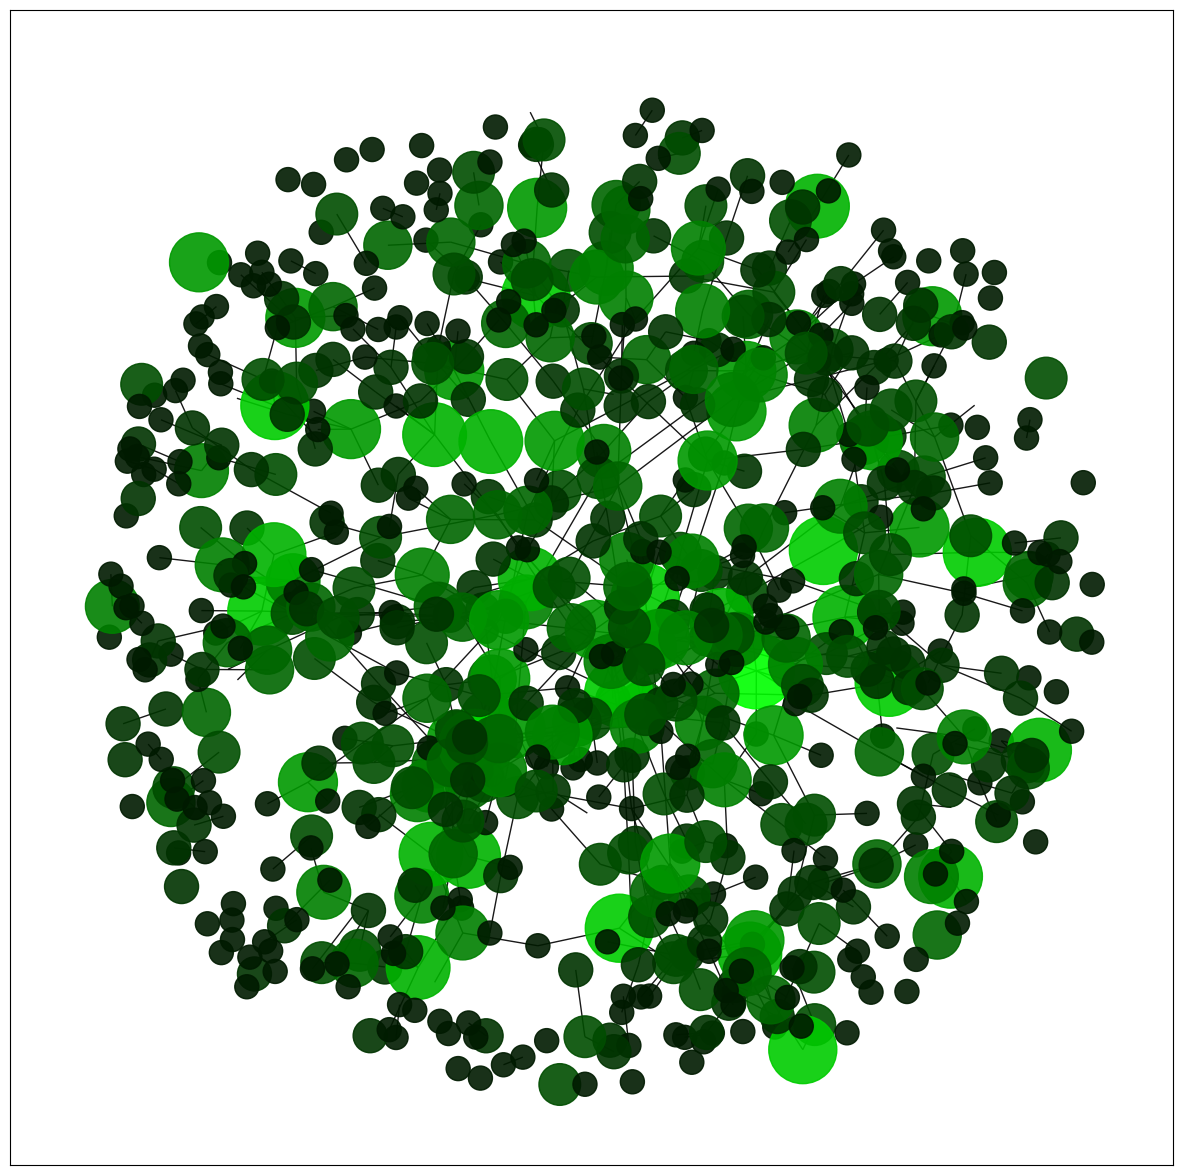

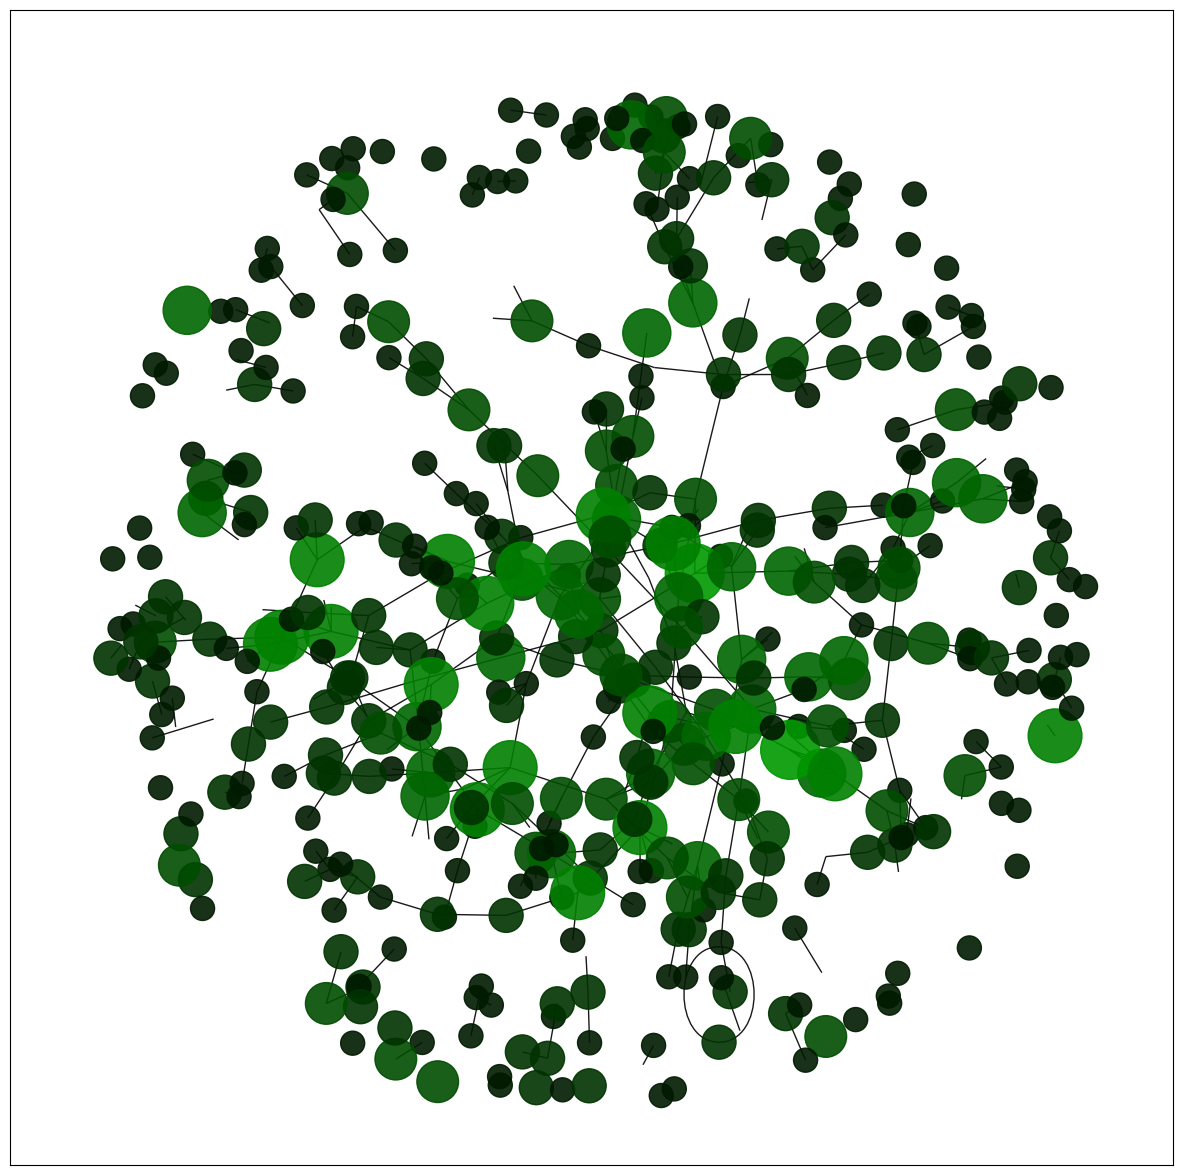


KeyboardInterrupt



<Figure size 1500x1500 with 0 Axes>

In [6]:
person_num  = 1000
connect_num = 1500
try_num = 20
find_num = 15
%matplotlib inline
titanic.start_connect(person_num,connect_num,try_num,find_num)

/var/folders/jg/d6c6lrt91lg0nx20yrhdxqvw0000gn/T/ipykernel_34534/1755388089.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(list(titanic.information_all[i+1].values()))[:,2:4]
/var/folders/jg/d6c6lrt91lg0nx20yrhdxqvw0000gn/T/ipykernel_34534/1755388089.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.scatter(x,y,c = np.array(list(titanic.information_all[1].values()))[:,1])
/var/folders/jg/d6c6lrt91lg0nx20yrhdxqvw0000gn/T/ipykernel_34534/1755388089.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested seque

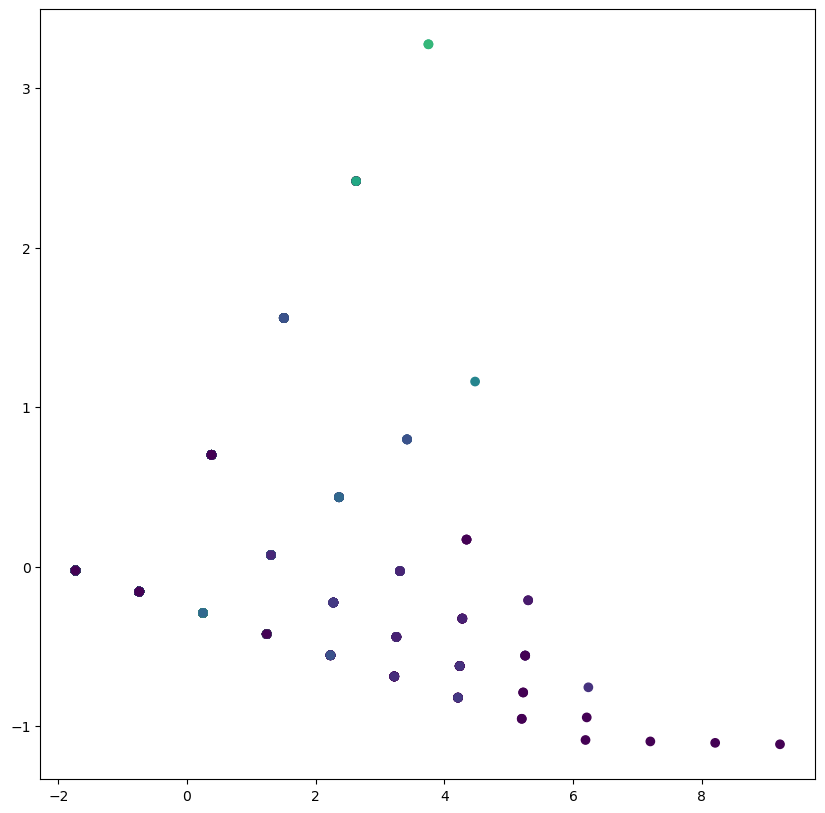

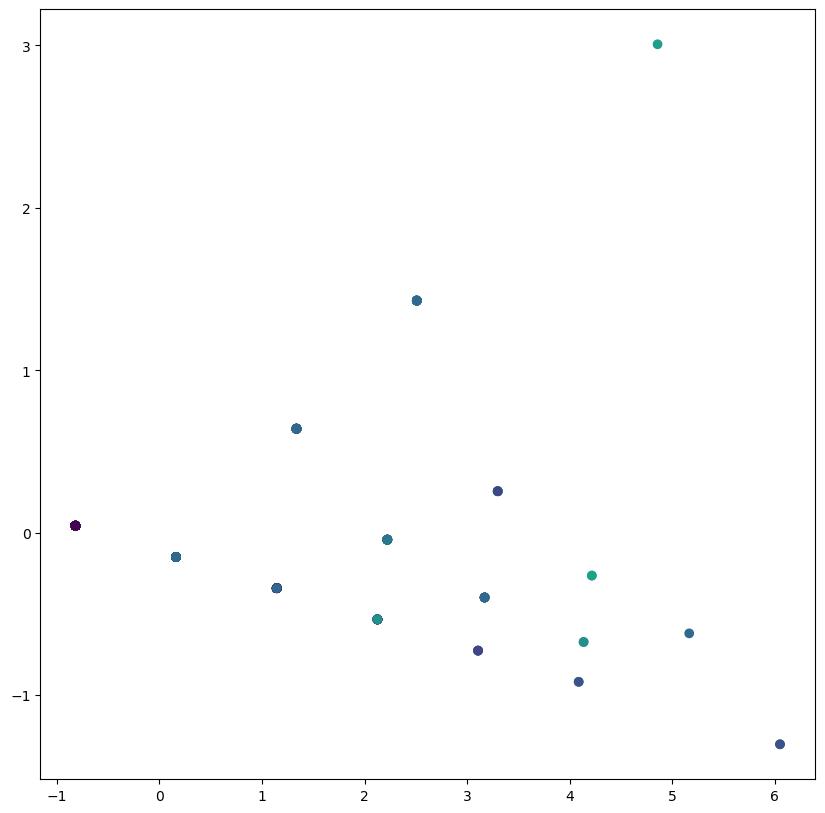

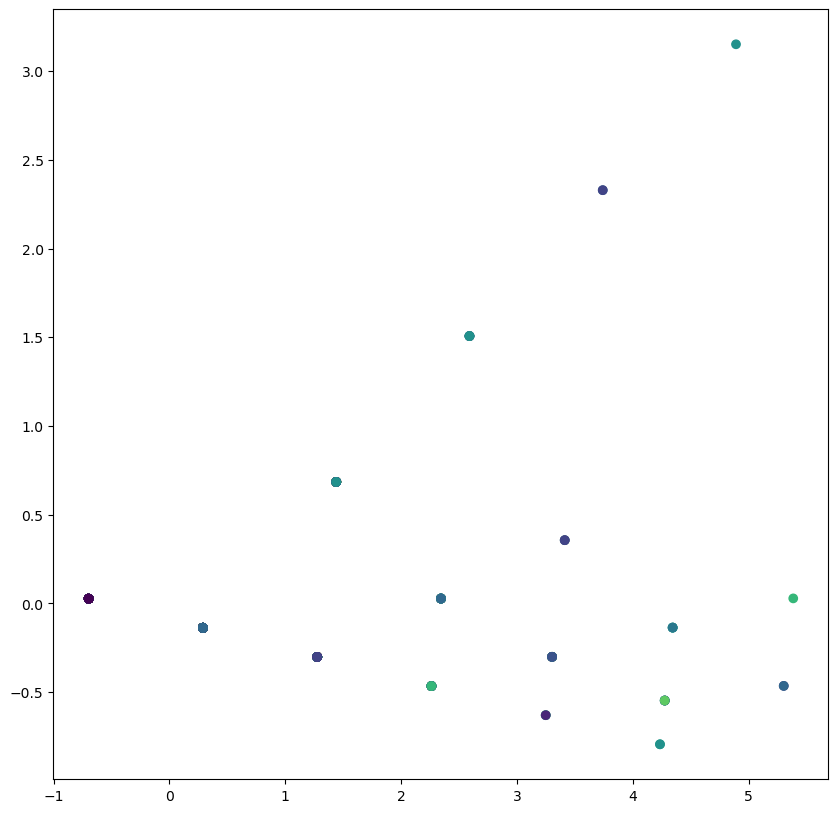

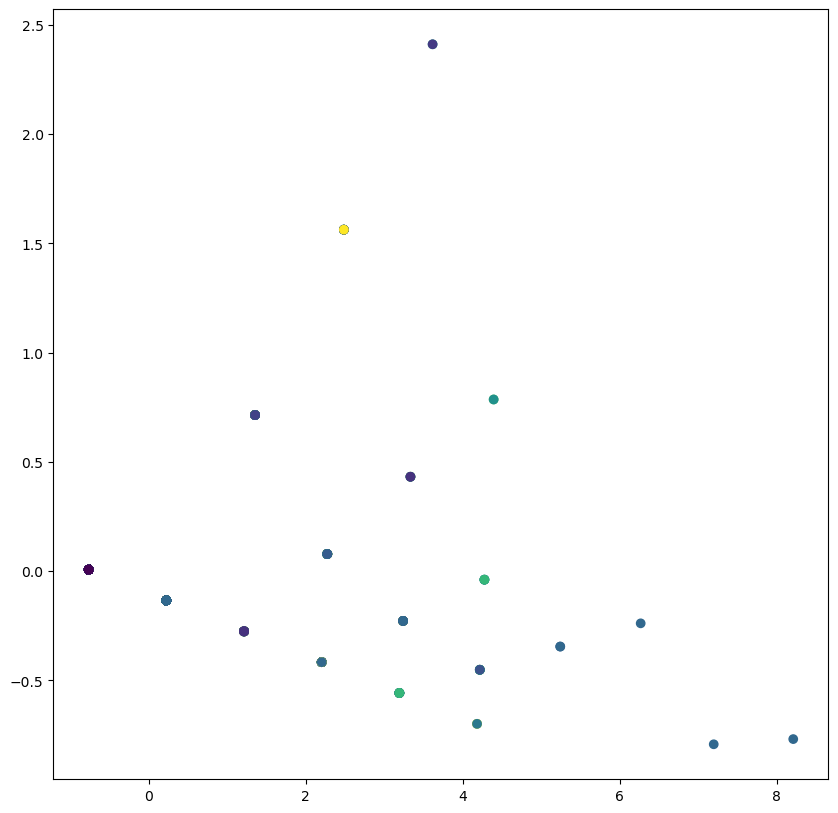

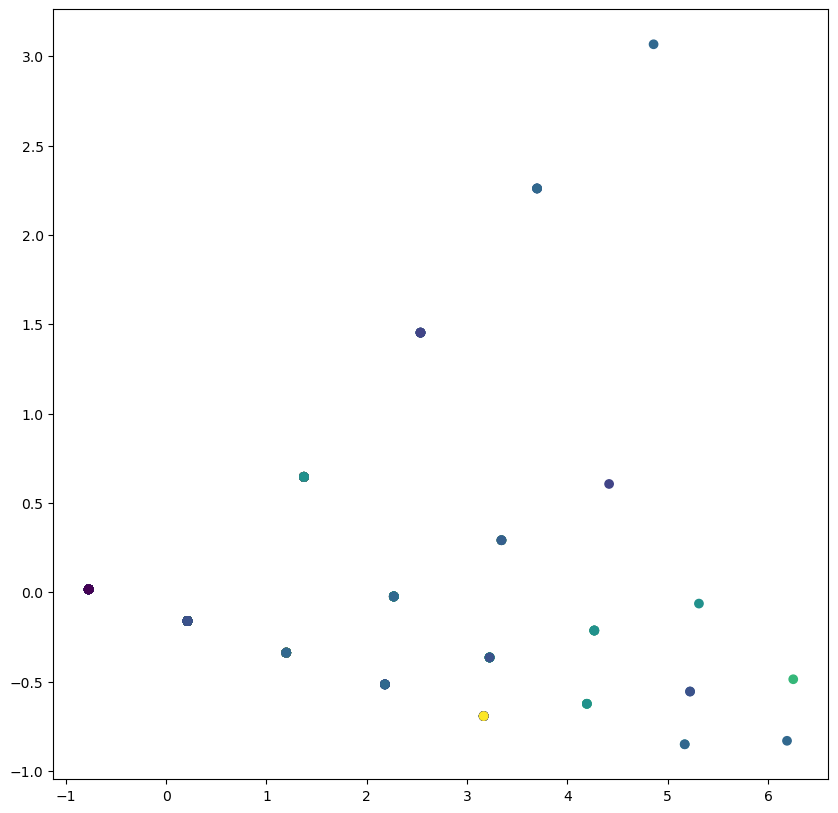

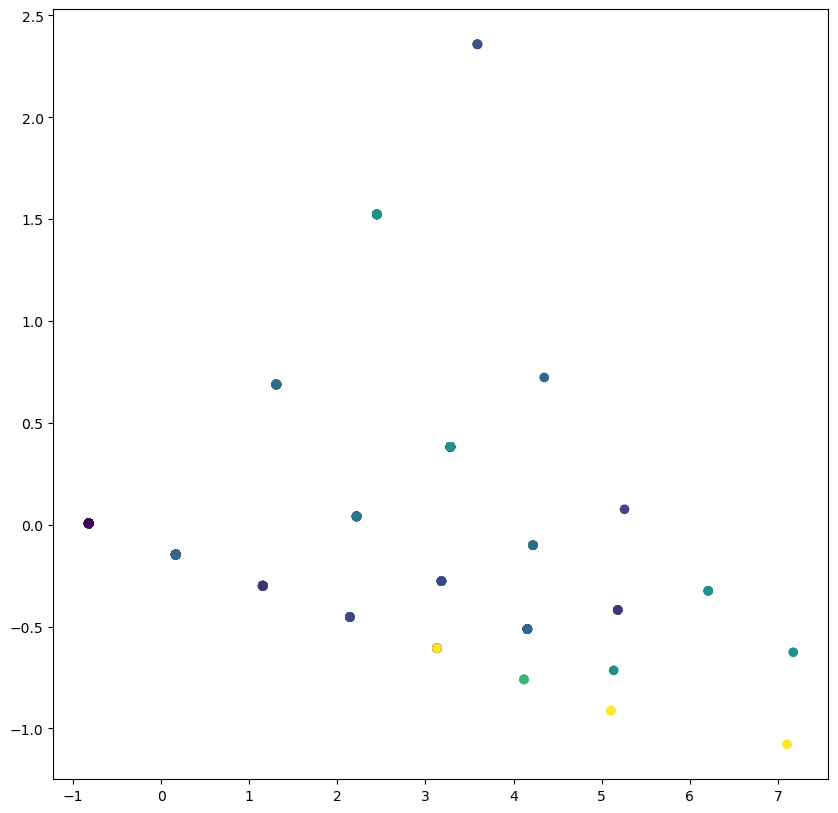

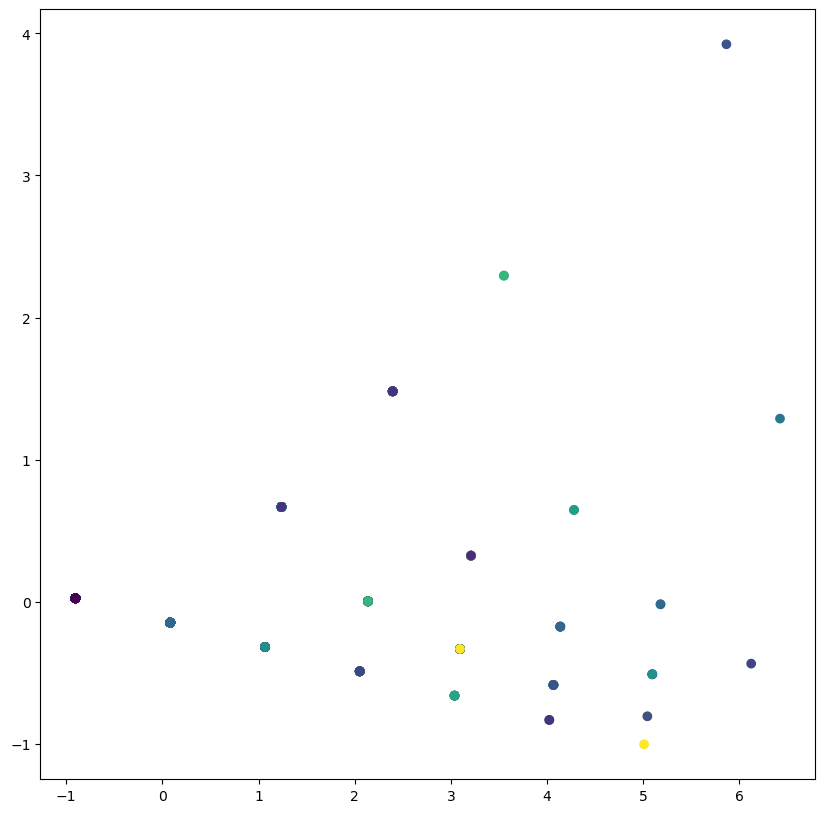

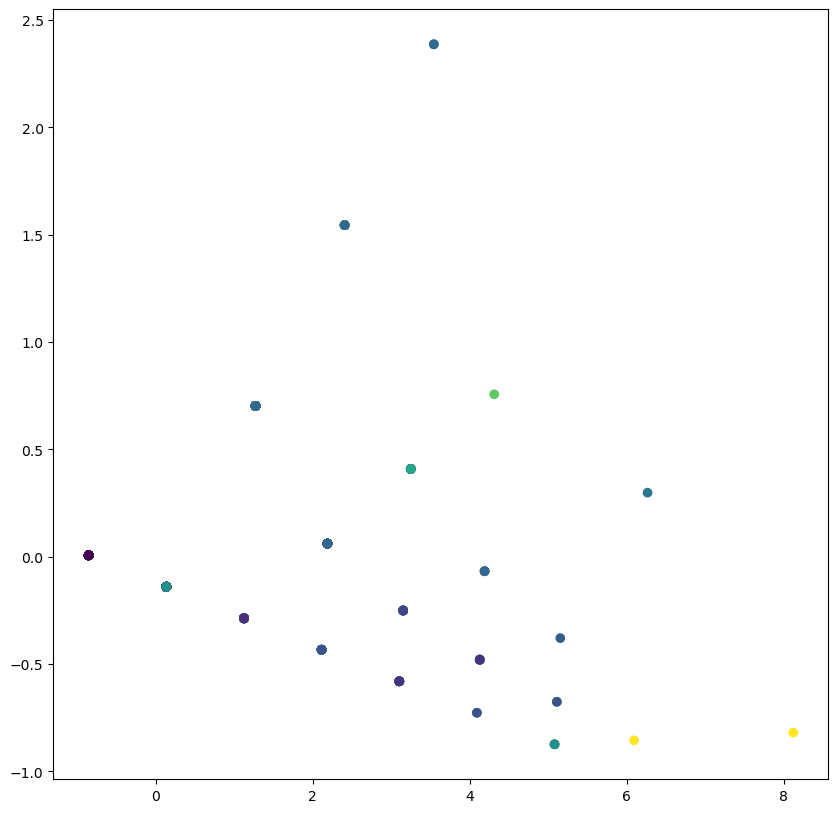

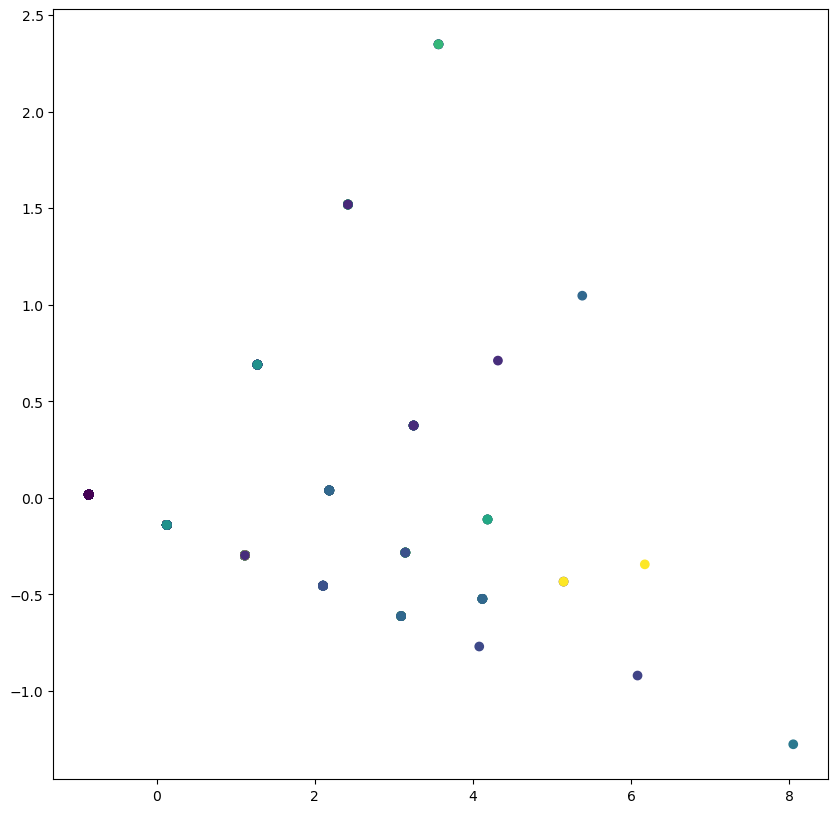

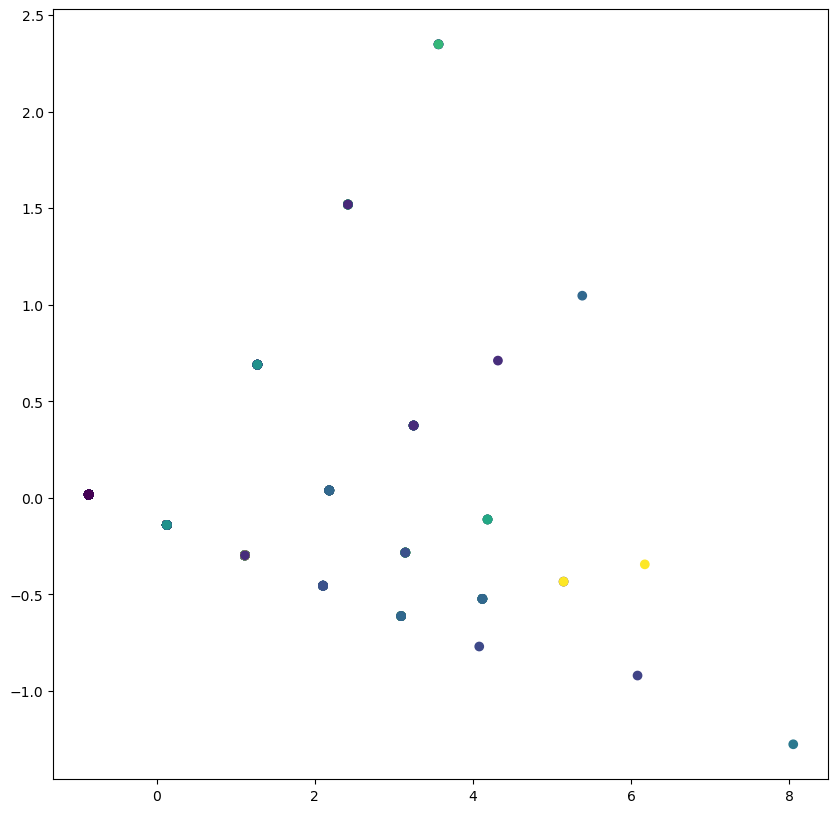

In [817]:
import numpy as np
from sklearn.decomposition import PCA


for i in range(10):
    data = np.array(list(titanic.information_all[i+1].values()))[:,2:4]
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    x = np.array(reduced_data.tolist())[:,0]
    y = np.array(reduced_data.tolist())[:,1]
    plt.figure(figsize = (10,10))
    plt.scatter(x,y,c = np.array(list(titanic.information_all[1].values()))[:,1])

    

In [313]:
import matplotlib.pyplot as plt
import networkx as nx
import random

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'AppleGothic'


def draw_network_graph(questions, fields):
    G = nx.Graph()
    sizes = []
    colors = []
    alphas = []

    # 질문들을 노드로 추가
    for i, (question, field) in enumerate(zip(questions, fields)):
        G.add_node(i, question=question, field=field)

    # 노드들을 랜덤하게 연결 (같은 분야 내에서 주로 연결, 다른 분야끼리는 가끔 연결)
    nodes = list(G.nodes)
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            if G.nodes[nodes[i]]['field'] == G.nodes[nodes[j]]['field'] and random.random() > 0.2:
                G.add_edge(nodes[i], nodes[j])
            elif G.nodes[nodes[i]]['field'] != G.nodes[nodes[j]]['field'] and random.random() > 0.95:
                G.add_edge(nodes[i], nodes[j])
        k = random.random()
        
        p=k+0.3
        sizes.append(k*3000)
        if p > 1:
            p = 1
        
        alphas.append(p)

    plt.figure(figsize=(20,20))

    plt.figure(figsize=(20,20))

    # 초기 노드 위치 설정
    initial_pos = {i: (random.uniform(0, 0.3 if field == 1 else 0.7 if field == 2 else 0.2),
                      random.uniform(0, 0.7 if field == 1 else 0.7 if field == 2 else 0.2)) for i, field in enumerate(fields)}

    pos = nx.fruchterman_reingold_layout(G, pos=nx.fruchterman_reingold_layout(G,seed=777,k = 100), seed=777)
    
    # 노드의 위치에서 y 좌표를 조금 올려서 레이블 위치를 정함
    label_pos = {node: (coordinates[0], coordinates[1] + 0.1) for node, coordinates in pos.items()}
    
    labels = nx.get_node_attributes(G, 'question')
    nx.draw_networkx_labels(G, label_pos, labels=labels, font_family='AppleGothic')
    
    # 노드의 색상을 필드에 따라 설정
    field_colors = {1: (p,0,0), 2: (0,p,0), 3: 'green'}
    for node in G.nodes:
        p = random.random()
        if G.nodes[node]['field'] == 1:
            colors.append((p,0,0))
        elif G.nodes[node]['field'] == 2:
            colors.append((0,p,0))
        else:
            colors.append((0,0,p))
    
    node_colors = [field_colors[G.nodes[node]['field']] for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_color=colors,node_size = sizes,alpha =alphas)
    
    nx.draw_networkx_edges(G, pos)

    plt.show()


